Гопиенко Александр КИ22-17/2Б
Практическая работа №1 по глубокому обучению

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

# Задача регрессии

In [48]:
# Определим пропуски в датасете
df = pd.read_csv('house_price.csv')
df = df.drop(columns=['id'])
missing_values = df.isnull().sum()
print(missing_values)

Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000                      0
Стоматол

### Информация о данных датафрейма

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    int64  
 4   Этажей.в.доме              808 non-null    int64  
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    int64  
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  

### Обработаем выбросы в датафрейме с помощью метода квантилей

In [50]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

columns_check_1 = df[['Общая.площадь', 'Этаж', 'Этажей.в.доме']]
columns_check_2 = df.loc[:, 'Школа.1000':'Аптека.1000']
columns_check = pd.concat([columns_check_1, columns_check_2], axis=1)

# Рассчитываем межквартильный размах (IQR) для всех столбцов
Q1 = columns_check.quantile(0.25)
Q3 = columns_check.quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для определения выбросов для всех столбцов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем значения, удаляя выбросы для всех столбцов
filtered_columns = {}
for col in columns_check.columns:
    filtered_columns[col] = columns_check[col][(columns_check[col] >= lower_bound[col]) & (columns_check[col] <= upper_bound[col])]

# Строим новый DataFrame с удаленными выбросами
df_cleaned = pd.concat([filtered_columns[col] for col in columns_check.columns], axis=1)

# Подсчитываем количество выбросов для каждого столбца
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        outliers = detect_outliers(df[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() / df[column].size), 2)})")

Количество выбросов в столбце 'Количество.комнат': 0 (0.0)
Количество выбросов в столбце 'Студия': 33 (0.04)
Количество выбросов в столбце 'Общая.площадь': 9 (0.01)
Количество выбросов в столбце 'Этаж': 38 (0.05)
Количество выбросов в столбце 'Этажей.в.доме': 48 (0.06)
Количество выбросов в столбце 'Парковка': 115 (0.14)
Количество выбросов в столбце 'Без.ремонта': 82 (0.1)
Количество выбросов в столбце 'Дизайнерский': 20 (0.02)
Количество выбросов в столбце 'Евроремонт': 82 (0.1)
Количество выбросов в столбце 'Косметический': 184 (0.23)
Количество выбросов в столбце 'Балкон': 8 (0.01)
Количество выбросов в столбце 'Лоджия': 139 (0.17)
Количество выбросов в столбце 'Совмещенный.санузел': 0 (0.0)
Количество выбросов в столбце 'Раздельный.санузел': 0 (0.0)
Количество выбросов в столбце 'Лифт': 3 (0.0)
Количество выбросов в столбце 'Грузовой.лифт': 74 (0.09)
Количество выбросов в столбце 'Мусоропровод': 0 (0.0)
Количество выбросов в столбце 'Год.постройки': 0 (0.0)
Количество выбросов в с

### Избавимся от образовавшихся пропусков и выполним нормализацию

In [51]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)


imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df = pd.DataFrame(df_filled, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    float64
 1   Студия                     808 non-null    float64
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    float64
 6   Без.ремонта                808 non-null    float64
 7   Дизайнерский               808 non-null    float64
 8   Евроремонт                 808 non-null    float64
 9   Косметический              808 non-null    float64
 10  Балкон                     808 non-null    float64
 11  Лоджия                     808 non-null    float64
 12  Совмещенный.санузел        808 non-null    float64
 13  Раздельный.санузел         808 non-null    float64

### Проверим данные на наличие коллинеарности и обработаем коррелирующие признаки

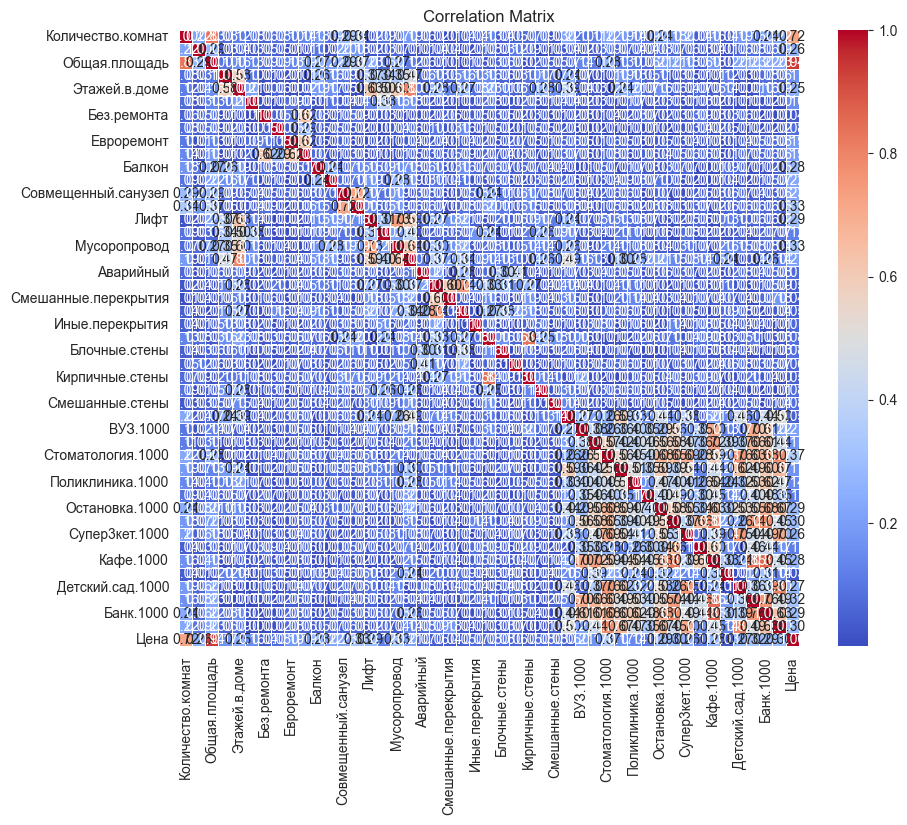

In [52]:
# Построение матрицы корреляции
correlation_matrix = df.corr().abs()

# Создание маски для отображения только верхнего треугольника матрицы корреляции
threshold = 0.8  # Порог корреляции 0.8

mask = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
collinear_features = [column for column in mask.columns if any(mask[column] > threshold)]

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Параметр 'Цена' является целевым, поэтому его не удаляем
# Обработка коллинеарности с помощью удаления одного из пары коррелирующих признаков
# Удаляем по одному признаку из каждой пары
df = df.drop(columns=collinear_features[1::2])

### Выполним масштабирование признаков

In [53]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data, columns=df.columns)
y = df.iloc[:, -1]
X = df.iloc[:, :-1]

## Обучим нейронную сеть

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель нейронной сети
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True)

# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks = [callback])

# Оценка качества модели на тестовой выборке
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Epoch 1/10
21/21 [==============================] - 1s 3ms/step - loss: 0.7431
Epoch 2/10
21/21 [==============================] - 0s 2ms/step - loss: 0.3593
Epoch 3/10
21/21 [==============================] - 0s 2ms/step - loss: 0.2487
Epoch 4/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1990
Epoch 5/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1686
Epoch 6/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1472
Epoch 7/10
21/21 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 8/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1179
Epoch 9/10
21/21 [==============================] - 0s 1ms/step - loss: 0.1069
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
Mean Squared Error on Test Set: 0.2099817921830154


Выполним подбор параметров для нейронной сети

In [55]:
# Функция для создания модели нейронной сети
def build_reg(optimizer='adam'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, callbacks = [callback])
    return model

# Создание экземпляра модели для использования в GridSearchCV
model = KerasRegressor(build_fn=build_reg)

# Определение сетки гиперпараметров для поиска
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

# Создание k-fold кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение поиска по сетке гиперпараметров
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, verbose=2)
grid_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print()

# Оценка качества модели с лучшими параметрами на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END .....................................optimizer=adam; total time=   1.8s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END .....................................optimizer=adam; total time=   2.1s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END .....................................optimizer=adam; total time=   1.6s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END .....................................optimizer=adam; total time=   2.1s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END .....................................optimizer=adam; total time=   2.1s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 1ms/step
[CV] END ......................................optimizer=sgd; total time=   5.8s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 1ms/step
[CV] END ......................................optimizer=sgd; total time=   2.3s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END ......................................optimizer=sgd; total time=   2.1s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 1ms/step
[CV] END ......................................optimizer=sgd; total time=   1.4s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END ......................................optimizer=sgd; total time=   1.8s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 1ms/step
[CV] END ..................................optimizer=rmsprop; total time=   1.7s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END ..................................optimizer=rmsprop; total time=   2.0s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END ..................................optimizer=rmsprop; total time=   1.9s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 2ms/step
[CV] END ..................................optimizer=rmsprop; total time=   1.9s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 1ms/step
[CV] END ..................................optimizer=rmsprop; total time=   1.8s


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


21/21 [==============================] - 0s 2ms/step - loss: 0.0149
Наилучшие гиперпараметры: {'optimizer': 'rmsprop'}

6/6 [==============================] - 0s 2ms/step
Mean Squared Error on Test Set: 0.1754841223391595


Вывод: результаты задачи регрессии с помощью нейронной сети лучше чем результаты регрессии с помощью моделей машинного обучения